## Preprocess images and save in another directory

In [23]:
import os
import glob
import nibabel as nib
from preprocess import preprocess_image
import numpy as np

In [27]:
path = "/Users/Thanh/master/Visualization_lab/SAM/database"
output_dir = os.path.join(path,"preprocess")
try:
    os.mkdir(output_dir)
except:
    pass
for folder in os.listdir(path):
    sub_dir = os.path.join(path, folder)
    if not os.path.isfile(sub_dir) and folder != "preprocess":
        output_subdir = os.path.join(output_dir,folder)
        try:
            os.mkdir(output_subdir)
        except:
            pass
        for sub_folder in os.listdir(sub_dir):
            input_folder = os.path.join(sub_dir,sub_folder)
            if not os.path.isfile(input_folder):
                output_folder = os.path.join(output_subdir,sub_folder)
                try:
                    os.mkdir(output_folder)
                except:
                    pass
                os.chdir(input_folder)
                for file in glob.glob("*.nii.gz"):
                    if "gt" in file:
                        image = nib.load(file)
                        pre_image = preprocess_image(image,is_seg = True, keep_z_spacing = True)
                        output = os.path.join(output_folder,file)
                        np.save(output.replace(".nii.gz",".npy"), pre_image)
                    elif ("frame" in file) and ("gt" not in file) :
                        image = nib.load(file)
                        pre_image = preprocess_image(image,is_seg = False, keep_z_spacing = True)
                        output = os.path.join(output_folder,file)
                        np.save(output.replace(".nii.gz",".npy"), pre_image)


    
    

training
patient015
patient015_frame01_gt.nii.gz
patient015_frame01.nii.gz
patient015_frame10.nii.gz
patient015_frame10_gt.nii.gz
patient012
patient012_frame13.nii.gz
patient012_frame01.nii.gz
patient012_frame01_gt.nii.gz
patient012_frame13_gt.nii.gz
patient024
patient024_frame01_gt.nii.gz
patient024_frame01.nii.gz
patient024_frame09_gt.nii.gz
patient024_frame09.nii.gz
patient023
patient023_frame01_gt.nii.gz
patient023_frame01.nii.gz
patient023_frame09_gt.nii.gz
patient023_frame09.nii.gz
patient048
patient048_frame08_gt.nii.gz
patient048_frame08.nii.gz
patient048_frame01_gt.nii.gz
patient048_frame01.nii.gz
patient083
patient083_frame08_gt.nii.gz
patient083_frame01.nii.gz
patient083_frame08.nii.gz
patient083_frame01_gt.nii.gz
patient077
patient077_frame01.nii.gz
patient077_frame01_gt.nii.gz
patient077_frame09.nii.gz
patient077_frame09_gt.nii.gz
patient070
patient070_frame01.nii.gz
patient070_frame01_gt.nii.gz
patient070_frame10_gt.nii.gz
patient070_frame10.nii.gz
patient084
patient084_f

## Segmentation pipeline

In [4]:
import os
import cv2
#Load the model
import torch
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

In [20]:
import gzip
os.chdir("/home/stud/nguyenp0/sam-lab")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [21]:
path = "/home/stud/nguyenp0/database/preprocess/training/patient001"
os.chdir(path)
os.listdir(path)
f = gzip.GzipFile(os.path.join(path,"patient001_frame01.npy.gz"), "r")
image = np.load(f)

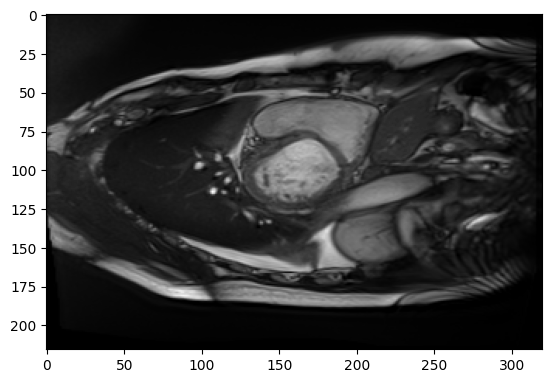

In [22]:
plt.imshow(image[:,:,1],cmap = "gray")

In [14]:
image.shape

(216, 320, 12)

In [26]:
def show_points(coords, labels, ax, marker_size=10):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='green', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='red', linewidth=1.25)   

import random
def sam_input(gt_image, label: int, n_points: int, input_image = np.array([None]), pixel_values = range(256)):
    '''
    Generates an array of a defined number of sampled points from one class of the gt_image.

    Arguments:
    gt_image: 2D-array, assigned labels of the original image
    label: integer, class to which the sam_points should belong
    n_points: number of points that should be returned
    input_image: array of input image for checking pixel values
    pixel_values: a range of pixel values that sam_points should have
    Returns:
    A numpy array of n points belonging to the label
    '''
    if input_image.any() != None:
        minimum = min(pixel_values)
        maximum = max(pixel_values)
        arr = np.where(gt_image == label,input_image,0)
        rows,cols = np.where((minimum <= arr) & (maximum >= arr))
        points = [[col, row] for row, col in zip(rows,cols)]

    else:
        rows,cols = np.where(gt_image == label)
        points = [[col, row] for row, col in zip(rows,cols)]
    assert len(points) >= n_points, f"Choose the number of points lower than {len(points)}"
    sam_points = np.array(random.sample(points, n_points))
    return sam_points

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


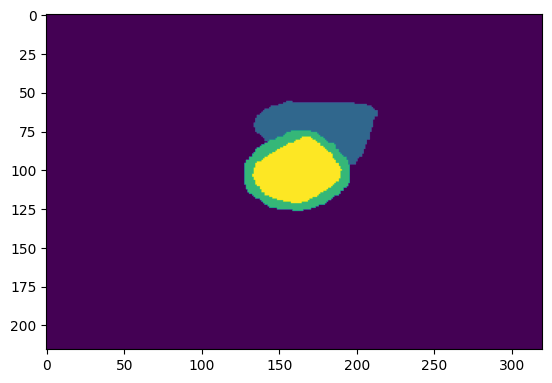

In [25]:
f1 = gzip.GzipFile(os.path.join(path,"patient001_frame01_gt.npy.gz"), "r")
gt_image = np.load(f1)
plt.imshow(gt_image[:,:,1])

In [90]:
num = 5
points_1 = sam_input(gt_image[:,:,1],1,num)
points_2 = sam_input(gt_image[:,:,1],2,num)
points_3 = sam_input(gt_image[:,:,1],3,num)
points = [points_1,points_2,points_3]
masks = []
#for ind in range(3):
print(points_1)
print(points_2)
print(points_3)

[[203  65]
 [161  57]
 [146  77]
 [180  65]
 [157  64]]
[[186 116]
 [166  78]
 [176  80]
 [179  85]
 [133  99]]
[[171 115]
 [187  99]
 [155  88]
 [154 111]
 [162 102]]


In [196]:
masks = np.zeros((image.shape[2],3,image.shape[0],image.shape[1]))
for i in range(1,image.shape[2]):
    print(i)
    img = cv2.cvtColor(image[:,:,i],cv2.COLOR_GRAY2RGB)
    sam_img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    sam_img = sam_img.astype(np.uint8)
    num = 5
    try:
        points_1 = sam_input(gt_image[:,:,i],1,num)
        points_2 = sam_input(gt_image[:,:,i],2,num)
        points_3 = sam_input(gt_image[:,:,i],3,num)
        input_points = np.concatenate((points_1,points_2,points_3))
        predictor = SamPredictor(sam)
        predictor.set_image(sam_img)
        image_embedding = predictor.get_image_embedding()
        for j in range(3):
            print(j)
            input_labels = np.zeros(num * 3)
            input_labels[j*num:(j+1)*num] = 1
            mask, scores, logits = predictor.predict(
                                                            point_coords=input_points,
                                                            point_labels=input_labels,
                                                            multimask_output=False
                                                        )
            masks[i,j,:,:] = mask
            mask = mask.astype(int)
        masks.append(masks)
    except:
        pass
mask_image = np.array(mask_image)

1
0
1
2
2
0
1
2
3
0
1
2
4
0
1
2
5
0
1
2
6
0
1
2
7
0
1
2
8
0
1
2
9
0
1
2
10
0
1
2
11
0
1
2


In [204]:
mask = masks[1,2,:,:]

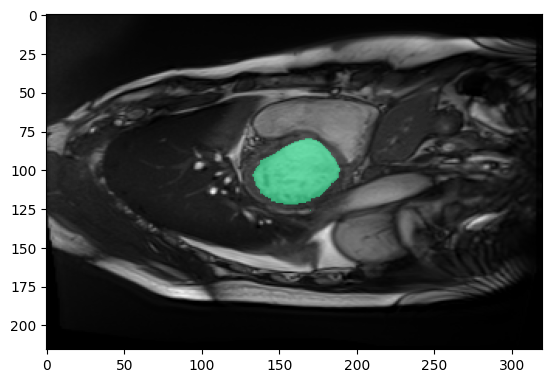

In [205]:
plt.imshow(image[:,:,1],cmap = "gray")
show_mask(mask, plt.gca(),random_color = True)
plt.axis('on')
plt.show()

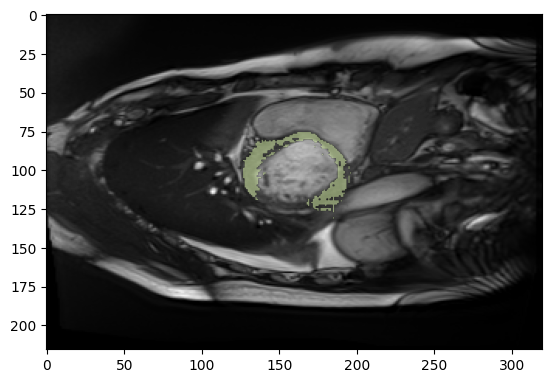

In [94]:
plt.imshow(image[:,:,1],cmap = "gray")
show_mask(masks[1], plt.gca(),random_color = True)
plt.axis('on')
plt.show()

In [89]:
m = np.concatenate(masks, axis = 0)
m.shape

(3, 216, 320)

In [68]:
points = np.concatenate((points_1,points_2,points_3))
points.shape

(30, 2)

In [119]:
mask_img = np.empty(shape= (image.shape[2],3,image.shape[0],image.shape[1]),dtype = int)

In [120]:
mask_img.shape

(12, 3, 216, 320)

In [127]:
mask_img[2,0,:,:] = np.ones((216,320))

In [128]:
mask_img[2,0,:,:]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [148]:
gt_image[gt_image[:,:,1] != 0]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 2., 3., ..., 2., 0., 0.],
       [0., 2., 3., ..., 2., 0., 0.],
       [0., 2., 3., ..., 2., 0., 0.]])

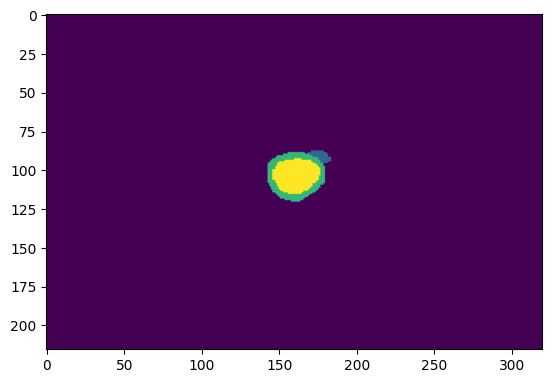

In [158]:
plt.imshow(gt_image[:,:,11])

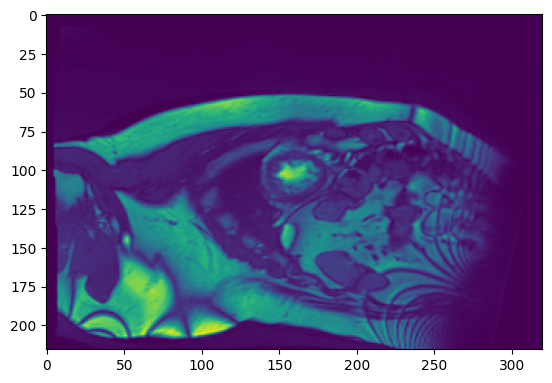

In [157]:
plt.imshow(image[:,:,11])

In [192]:
mask_image = np.empty(shape = (image.shape[2],3,image.shape[0],image.shape[1]), dtype = bool)

In [193]:
mask_image

array([[[[ True,  True,  True, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, Fa